![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/90.3.Financial_Table_Signature_Extraction.ipynb)

# Financial Table and Signature Extraction

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs
! pip install transformers
! python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, finance, visual

# nlp.install(force_browser=True, visual=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

In [ ]:
! pip install -U Pillow==9.4.0

**Restart the session and run and run the cells from here.**

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from johnsnowlabs import nlp, finance, visual

spark = nlp.start(visual=True)

**Restart the session and run and run the cells from here.**

In [ ]:
import os
os.kill(os.getpid(), 9)

# Start the session

In [ ]:
from johnsnowlabs import nlp, finance, visual

spark = nlp.start(visual=True)

******************************
# <b><h1><font color='orange'>This notebook consists of four parts :</font><h1><b>

  ### - Spark OCR Visual Document Classification
  ### - Signature Detection 
  ### - Table Recognition
  ### - Receipt Binary Classification
******************************

## Download and Read Sample images

In [ ]:
import pyspark.sql.functions as F

! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/signature/image_147.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_advertisement2.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_%20letter2.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_advertisement.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_budget2.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_email2.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_form.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_invoice3.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_invoice4.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_letter.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_news%20article.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_presentation.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_resume.png
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/tab_images/cTDaR_t10168.jpg
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr/master/python/sparkocr/resources/ocr/images/check.jpg?token=GHSAT0AAAAAABVMES4Q2ZOJEOUXLTCY7TDCYZDDW3A
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/visual_document_sample_images/financial_table_extraction.png


In [ ]:
sample_images = spark.read.format("binaryFile").load("*.png").cache()
sample_images.show()

# Display images

In [ ]:
image_df = visual.BinaryToImage().transform(sample_images)
visual.display_images(image_df)

# Spark OCR Visual Document Classification

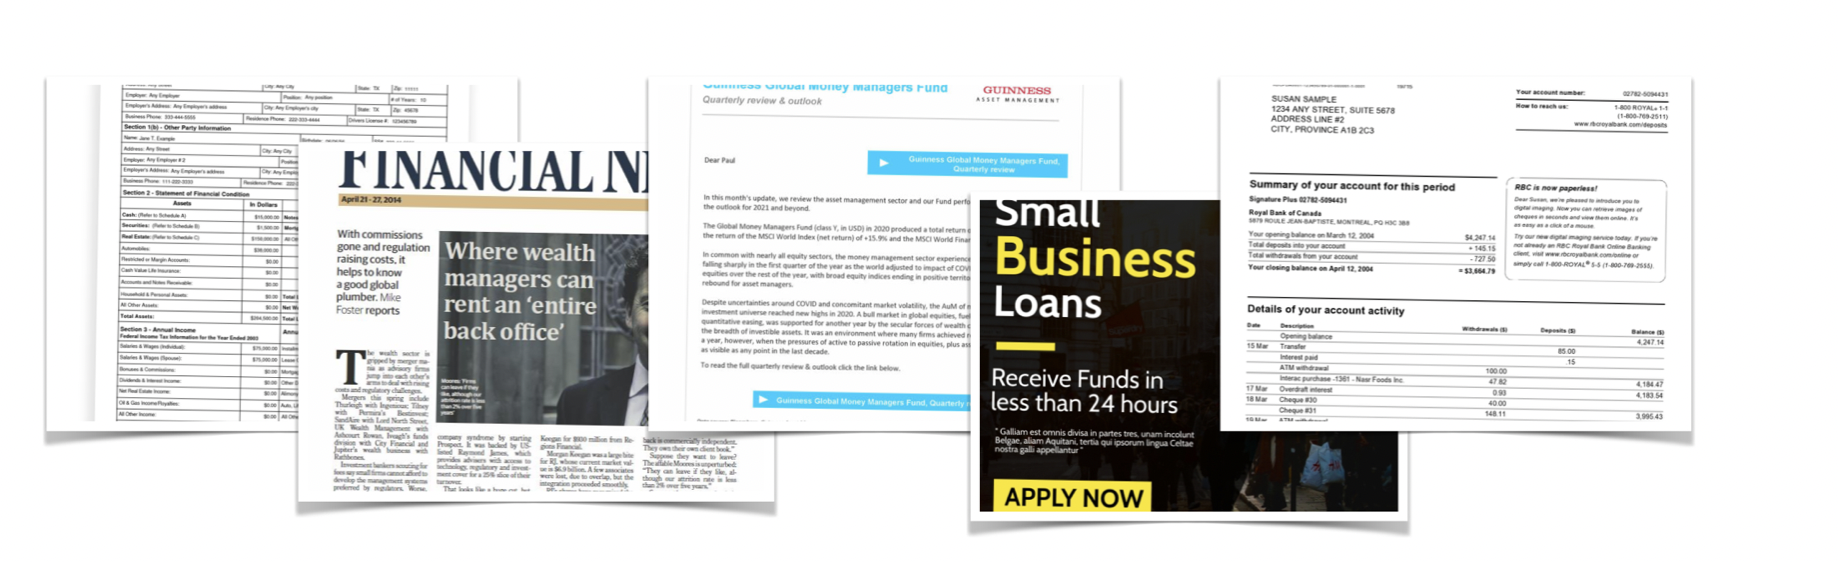

🔎With this model, you can classify financial documents using text and layout data with new features offered by Spark OCR.

🔎Classes detected by the model:

`letter`
`form`
`email`
`handwritten`
`advertisement`
`scientific report`
`scientific publicatio`
`specification`
`file folder`
`news article`
`budget`
`invoice`
`presentation`
`questionnaire`
`resume`
`memo`

In [ ]:
# from sparkocr.utils import get_vocabulary_dict

binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

doc_class = visual.VisualDocumentClassifierV3() \
    .pretrained("dit_base_finetuned_rvlcdip", "en", "clinical/ocr") \
    .setInputCols(["image"])\
    .setOutputCol("label")

pipeline = nlp.PipelineModel(stages=[binary_to_image,
                                 doc_class])

In [ ]:
results = pipeline.transform(sample_images).cache()

In [ ]:
results

In [ ]:
results.select("image", "label")

### Our Visual Document Classifier model has predicted the class of each image as seen above,  some of the documents are `financial`.

# Signature Detection 

## Display Image

In [ ]:

imagePath = "./image_147.png"

# Read image file as binary file
df = spark.read.format("binaryFile").load(imagePath)

visual.display_images(visual.BinaryToImage().transform(df), "image")

ImageHandwrittenDetector is a DL model for detect handwritten text on the image.

Detector support following labels:

`signature`
`date`
`name`
`title`
`address`
`others`

We will detect `signature` here :

## Define OCR Pipeline for Signature Detection 

In [ ]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0628", "en", "public/ocr/models")
signature_detector =  visual.ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("signature_regions") \
    .setOutputLabels(["signature"]) \
    .setScoreThreshold(0.4)

draw_regions =  visual.ImageDrawRegions() \
   .setInputCol("image") \
   .setInputRegionsCol("signature_regions") \
   .setOutputCol("image_with_regions") \
   .setFontSize(16) \
   .setRectColor(visual.Color.red)

pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    signature_detector,
    draw_regions
])

In [ ]:
result =  pipeline.transform(df).cache()
visual.display_images(result, "image_with_regions")

### Display coordinates of regions

In [ ]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(result['path'], '/')

# from pyspark2.4
results.withColumn("filename", F.element_at(F.split("path", "/"), -1)) \

result.withColumn("coordinate", F.explode_outer(result["signature_regions"])) \
    .withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn('signed', F.size(result["signature_regions"]) > 0) \
    .select("filename", "signed", "coordinate") \
    .show(truncate=False)

# Table Recognition


## Dısplay Image

In [ ]:


imagePath = "./financial_table_extraction.png"

# Read image file as binary file
df = spark.read.format("binaryFile").load(imagePath)

visual.display_images(visual.BinaryToImage().transform(df), "image")

🔎 `ImageTableDetector` is a DL model for detecting tables on the image.
`ImageTableCellDetector` detect cells in a table image.
`ImageCellsToTextTable` runs OCR for cells regions on image, return recognized text to outputCol as TableContainer structure.

## Define OCR Pipeline for Table Recognition

In [ ]:
binary_to_image =  visual.BinaryToImage()

table_detector =  visual.ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

splitter =  visual.ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")
splitter.setImageType(visual.ImageType.TYPE_BYTE_GRAY)

scaler =  visual.ImageScaler()
scaler.setInputCol("table_image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2)

cell_detector =  visual.ImageTableCellDetector()
cell_detector.setInputCol("scaled_image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)

table_recognition =  visual.ImageCellsToTextTable()
table_recognition.setInputCol("scaled_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(2)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    scaler,
    cell_detector,
    table_recognition
])

### Example-1

In [ ]:
results = pipeline.transform(df).cache()
visual.display_images(results, "table_image")

## Display recognized tables

In [ ]:
# from sparkocr.utils import display_images, display_tables, display_table
visual.display_tables(results)